In [3]:
import tensorflow as tf
import numpy as np
import math
import os
#import sklearn

#compression
import pickle
import bz2

#timing
import time

#plotting
import matplotlib.pyplot as plt

In [4]:
def get_runtime(func):
    """Decorator to get the various runtimes of different functions

        Runs specified input function and times execution time
    """
    def time_func(*args,**kwargs):
        start = time.time()
        res = func(*args, **kwargs)
        end = time.time()
        print(f"The function {func.__name__} took {end-start} seconds to run")
        return res
    return time_func

In [5]:
class Model:
    """Create a Convolutional Neural Network with outputs into dense layers

    Validation set validates our model performance during training,
    reducing problems such as overfitting


    May get the warning message:
        'This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use
        the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
        To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags'

        Which is not an error, just saying can take advantange of other CPU optimizations

    Parameters
    ----------
    train_x : numpy.ndarray
        Training ECG data
    train_y : numpy.ndarray
        Training ECG labels
    test_x : numpy.ndarray
        Testing ECG data
    test_y : numpy.ndarray
        Testing ECG labels

    Returns
    -------
    Sequential
        A CNN model

    """

    def __init__(self, train_X, train_y, test_X, test_y):

        #compiled network
        self.compiled = self.compile()

        self.train_X = train_X
        self.train_y = train_y

        self.test_X = test_X
        self.test_y = test_y

        #taking 50% of testing for a split of 70 training 15 validation 15 testing
        self.validation_X = test_X[( (len(test_X)//2) ):]
        self.test_X = test_X[:( (len(test_X)//2) )]

        self.validation_y = test_y[( (len(test_y)//2) ):]
        self.test_y = test_y[:( (len(test_y)//2) )]



    def compile(self):
        """
        Convolutional layer --> Fully connected layer

        _________________________________________________________________
        Layer (type)                Output Shape              Param #   
        =================================================================
        input_1 (InputLayer)        [(None, 12, 2500)]        0         
                                                                 
        conv1d (Conv1D)             (None, 6, 32)             240032    
                                                                 
        batch_normalization (BatchN  (None, 6, 32)            128       
        ormalization)                                                   
                                                                 
        conv1d_1 (Conv1D)           (None, 3, 64)             6208      
                                                                 
        batch_normalization_1 (Batc  (None, 3, 64)            256       
        hNormalization)                                                 
                                                                 
        conv1d_2 (Conv1D)           (None, 2, 128)            41088     
                                                                 
        batch_normalization_2 (Batc  (None, 2, 128)           512       
        hNormalization)                                                 
                                                                 
        conv1d_3 (Conv1D)           (None, 1, 256)            164096    
                                                                 
        batch_normalization_3 (Batc  (None, 1, 256)           1024      
        hNormalization)                                                 
                                                                 
        conv1d_4 (Conv1D)           (None, 1, 512)            918016    
                                                                 
        batch_normalization_4 (Batc  (None, 1, 512)           2048      
        hNormalization)                                                 
                                                                 
        conv1d_5 (Conv1D)           (None, 1, 1024)           3671040   
                                                                 
        batch_normalization_5 (Batc  (None, 1, 1024)          4096      
        hNormalization)                                                 
                                                                 
        dropout (Dropout)           (None, 1, 1024)           0         
                                                                 
        flatten (Flatten)           (None, 1024)              0         
                                                                 
        dense (Dense)               (None, 4096)              4198400   
                                                                 
        dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
        dense_1 (Dense)             (None, 2048)              8390656   
                                                                 
        dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
        dense_2 (Dense)             (None, 1024)              2098176   
                                                                 
        dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
        dense_3 (Dense)             (None, 128)               131200    
                                                                 
        dense_4 (Dense)             (None, 1)                 129       
                                                                 
        =================================================================
        Total params: 19,867,105
        Trainable params: 19,863,073
        Non-trainable params: 4,032
        _________________________________________________________________

        """
        input_layer = tf.keras.Input(shape=(12, 2500))

        #expanding output space
        x = tf.keras.layers.Conv1D(
            filters=32, kernel_size=3, strides=2, activation="relu", padding="same"
        )(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=64, kernel_size=3, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=128, kernel_size=5, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=256, kernel_size=5, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=512, kernel_size=7, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv1D(
        filters=1024, kernel_size=7, strides=2, activation="relu", padding="same"
        )(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Flatten()(x)

        x = tf.keras.layers.Dense(4096, activation="relu")(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(
        2048, activation="relu", kernel_regularizer='l2'
        )(x)
        x = tf.keras.layers.Dropout(0.2)(x)

        x = tf.keras.layers.Dense(
        1024, activation="relu", kernel_regularizer='l2'
        )(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(
        128, activation="relu", kernel_regularizer='l2'
        )(x)
        output_layer = tf.keras.layers.Dense(1, activation="sigmoid")(x)

        model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
        print(model.summary())


        optimizer = tf.keras.optimizers.Adam(amsgrad=True, learning_rate=0.001)
        loss = tf.keras.losses.BinaryCrossentropy()

        #compiling model
        model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=[
            tf.keras.metrics.Accuracy(),
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            ],
            )

        return model

In [6]:
class Train:

    """Trains our fully connected Neural Network

    Parameters:
    ----------
    model : Sequential
        A NN model, compiled as specified by the Model class above

    Stores:
    -------
    self.compliled : Sequential
        compiled CNN model containing build specified in Model class
    self.trained_model :
        Trained CNN fit on training data

    """

    def __init__(self,model):
        self.model = model
        self.compiled = model.compiled
        self.trained_model, self.model_history = self.train_model(self.compiled, self.model)

    @get_runtime #prints runtime to train the model
    def train_model(self, compiled, model):
        """Returns a compiled (trained) model
        """

        #training the model on training data
        #starting with 20 epochs, if still improving performance will increase
        model_history = compiled.fit(
        x = model.train_X,
        y = model.train_y,
        epochs = 100,
        validation_data = (model.validation_X, model.validation_y)
        )

        return compiled, model_history

In [7]:
class Evaluate:
    """Evaluates model performance on our testing data

        Parameters:
        -----------
        compiled_model : keras Model class
            compiled model from Model() class
        trained_model : keras Model class
            trained model from Train() class

        Stores:
        --------
        loss :
            BinaryCrossentropy
        accuracy :
            Accuracy metric
        auc :
            Area Under Curve
        precision :
            precision preformance metric
        recall :
            recall preformance metric

    """

    def __init__(self,compiled, trained_model):
        self.compiled = compiled
        self.trained_model = trained_model

        self.loss, self.accuracy, self.auc, self.precision, self.recall  = self.trained_model.trained_model.evaluate(compiled.test_X,compiled.test_y)


In [8]:
def splitExamples(data,labels,split_factor):
    """Splits data and labels into separate training / testing arrays

        Parameters:
        -----------
        data : np array
            ECG waveform data
        labels : np array
            labels associated with an example
        split_factor : float range (0-1)
            What proportion of examples will be training (0.8 = 80%)

        Returns:
        --------
        train_X : numpy.ndarray
            training examples
        train_y: numpy.ndarray
            training labels
        test_X: numpy.ndarray
            testing examples
        test_y: numpy.ndarray
            testing labels
    """

    #going to split 70/30 for now (70 train, 15 val, 15 test)

    #splitting training data
    trainx = data[:int(len(data)*split_factor)]
    trainy = labels[:int(len(labels)*split_factor)]

    #splitting testing data
    testx = data[int(len(data)*split_factor):]
    testy = labels[int(len(labels)*split_factor):]

    return trainx, trainy, testx, testy

In [9]:
    #loading data and labels
    in_file = bz2.BZ2File("/Users/lukelorenz/Desktop/ECGNN/sim_ecg_data.bz2",'rb')
    data = pickle.load(in_file)
    in_file.close()

    in_file = bz2.BZ2File("/Users/lukelorenz/Desktop/ECGNN/sim_ecg_labels.bz2",'rb')
    labels = pickle.load(in_file)
    in_file.close()

    print(data.shape)

(1000, 12, 2500)


In [10]:
x_train, y_train, x_test, y_test = splitExamples(data,labels, 0.7)

In [11]:
compiled_model = Model(x_train, y_train, x_test, y_test)

2022-11-29 19:07:52.884202: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 19:07:52.885328: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12, 2500)]        0         
_________________________________________________________________
conv1d (Conv1D)              (None, 6, 32)             240032    
_________________________________________________________________
batch_normalization (BatchNo (None, 6, 32)             128       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             6208      
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 64)             256       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            41088     
_________________________________________________________________
batch_normalization_2 (Batch (None, 2, 128)            512   

In [12]:
trained_model = Train(compiled_model)
print("done training")

Train on 700 samples, validate on 150 samples
Epoch 1/100
700/700 [==============================] - 11s 16ms/sample - loss: 29.4833 - accuracy: 0.0000e+00 - auc: 0.4876 - precision: 0.4658 - recall: 0.4399 - val_loss: 15.3082 - val_accuracy: 0.0000e+00 - val_auc: 0.5902 - val_precision: 0.5333 - val_recall: 1.0000
Epoch 2/100
700/700 [==============================] - 7s 9ms/sample - loss: 9.2267 - accuracy: 0.0000e+00 - auc: 0.6171 - precision: 0.5782 - recall: 0.5748 - val_loss: 5.0429 - val_accuracy: 0.0000e+00 - val_auc: 0.5788 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 3/100
700/700 [==============================] - 8s 12ms/sample - loss: 3.5227 - accuracy: 0.0000e+00 - auc: 0.7340 - precision: 0.6727 - recall: 0.6569 - val_loss: 2.5546 - val_accuracy: 0.0000e+00 - val_auc: 0.5588 - val_precision: 0.6429 - val_recall: 0.1125
Epoch 4/100
700/700 [==============================] - 8s 12ms/sample - loss: 1.9714 - accuracy: 0.0000e+00 - auc: 0.8030 - precision: 0.7309 - reca

Epoch 32/100
700/700 [==============================] - 9s 13ms/sample - loss: 0.0619 - accuracy: 0.0829 - auc: 0.9981 - precision: 0.9970 - recall: 0.9853 - val_loss: 3.2540 - val_accuracy: 0.0067 - val_auc: 0.5706 - val_precision: 0.6250 - val_recall: 0.4375
Epoch 33/100
700/700 [==============================] - 9s 13ms/sample - loss: 0.0917 - accuracy: 0.0186 - auc: 0.9964 - precision: 0.9767 - recall: 0.9824 - val_loss: 2.9753 - val_accuracy: 0.0200 - val_auc: 0.6119 - val_precision: 0.6538 - val_recall: 0.4250
Epoch 34/100
700/700 [==============================] - 9s 13ms/sample - loss: 0.1292 - accuracy: 0.0071 - auc: 0.9905 - precision: 0.9644 - recall: 0.9531 - val_loss: 2.1510 - val_accuracy: 0.0133 - val_auc: 0.5653 - val_precision: 0.6023 - val_recall: 0.6625
Epoch 35/100
700/700 [==============================] - 9s 13ms/sample - loss: 0.1064 - accuracy: 0.0171 - auc: 0.9953 - precision: 0.9791 - recall: 0.9619 - val_loss: 2.5412 - val_accuracy: 0.0000e+00 - val_auc: 0.56

700/700 [==============================] - 7s 10ms/sample - loss: 0.0330 - accuracy: 0.0371 - auc: 0.9996 - precision: 0.9913 - recall: 0.9971 - val_loss: 2.7269 - val_accuracy: 0.0000e+00 - val_auc: 0.5291 - val_precision: 0.5833 - val_recall: 0.6125
Epoch 64/100
700/700 [==============================] - 7s 10ms/sample - loss: 0.0229 - accuracy: 0.0029 - auc: 0.9999 - precision: 0.9971 - recall: 0.9941 - val_loss: 3.5267 - val_accuracy: 0.0067 - val_auc: 0.5402 - val_precision: 0.5652 - val_recall: 0.4875
Epoch 65/100
700/700 [==============================] - 7s 9ms/sample - loss: 0.0352 - accuracy: 0.0286 - auc: 0.9996 - precision: 0.9970 - recall: 0.9883 - val_loss: 2.8455 - val_accuracy: 0.0000e+00 - val_auc: 0.5334 - val_precision: 0.5854 - val_recall: 0.6000
Epoch 66/100
700/700 [==============================] - 7s 9ms/sample - loss: 0.0381 - accuracy: 0.0057 - auc: 0.9996 - precision: 0.9941 - recall: 0.9824 - val_loss: 2.8806 - val_accuracy: 0.0067 - val_auc: 0.5278 - val_pr

700/700 [==============================] - 7s 9ms/sample - loss: 0.0341 - accuracy: 0.0786 - auc: 0.9982 - precision: 0.9942 - recall: 1.0000 - val_loss: 3.9196 - val_accuracy: 0.0400 - val_auc: 0.5517 - val_precision: 0.5625 - val_recall: 0.4500
Epoch 95/100
700/700 [==============================] - 7s 10ms/sample - loss: 0.0277 - accuracy: 0.1257 - auc: 0.9999 - precision: 1.0000 - recall: 0.9912 - val_loss: 3.7863 - val_accuracy: 0.0133 - val_auc: 0.5352 - val_precision: 0.5616 - val_recall: 0.5125
Epoch 96/100
700/700 [==============================] - 7s 10ms/sample - loss: 0.0413 - accuracy: 0.0457 - auc: 0.9996 - precision: 0.9826 - recall: 0.9941 - val_loss: 3.2142 - val_accuracy: 0.0133 - val_auc: 0.5220 - val_precision: 0.5846 - val_recall: 0.4750
Epoch 97/100
700/700 [==============================] - 7s 10ms/sample - loss: 0.0226 - accuracy: 0.0314 - auc: 1.0000 - precision: 0.9971 - recall: 0.9941 - val_loss: 3.5023 - val_accuracy: 0.0133 - val_auc: 0.5190 - val_precision

In [13]:
evaluate_model = Evaluate(compiled_model, trained_model)

150/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [14]:
print(f"Loss : {evaluate_model.loss}")
#print(f"Accuracy : {evaluate_model.accuracy}")
print(f"Area under the Curve (ROC) : {evaluate_model.auc}")
print(f"Precision : {evaluate_model.precision}")
print(f"Recall : {evaluate_model.recall}")

Loss : 2.873535404205322
Area under the Curve (ROC) : 0.569887638092041
Precision : 0.5625
Recall : 0.5696202516555786


In [15]:
def plot_history_metrics(history: tf.keras.callbacks.History):
    total_plots = len(history.history)
    cols = total_plots // 2

    rows = total_plots // cols

    if total_plots % cols != 0:
        rows += 1

    pos = range(1, total_plots + 1)
    plt.figure(figsize=(15, 10))
    for i, (key, value) in enumerate(history.history.items()):
        plt.subplot(rows, cols, pos[i])
        plt.plot(range(len(value)), value)
        plt.title(str(key))
    plt.show()

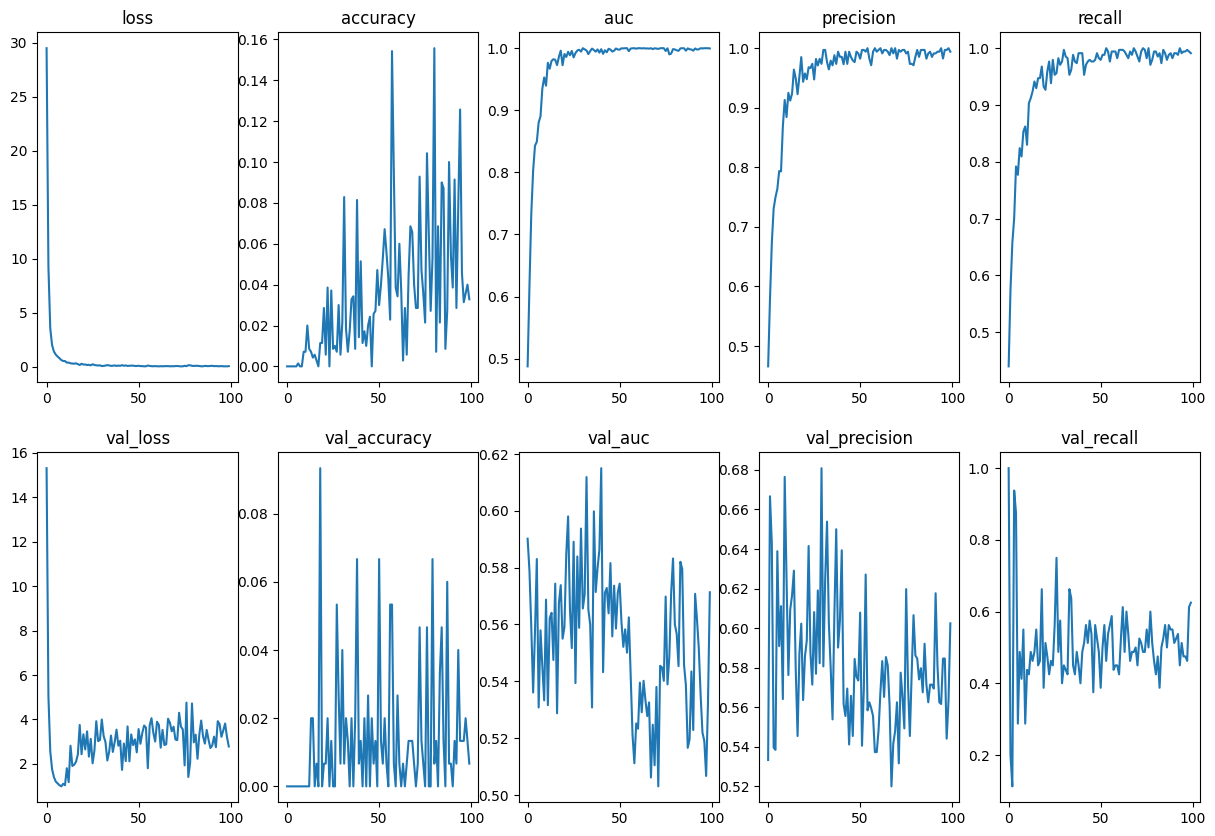

In [16]:
#Visualize model metrics during training
plot_history_metrics(trained_model.model_history)